# XILLVER emulation demo

With a feed-forward neural network emulator built and trained by Maggie in Tensorflow.

`emullver.py` contains a set of helper functions for using the model <br>
`xspec_comparison` contains functions for extracting xspec spectra and plotting a comparison between the emulated and xspec spectra

### Details to note:
- The model was saved with **Keras 2.15 and TensorFlow < 2.5 --> make sure to install tensorflow 2.15**, otherwise the backwards compatibility in Keras 3 doesn't quite work 
- The model was trained on extended xillver tables with 4999 energy bins between 0.1 eV and 10^3 keV
- Data preprocessing includes a log10 operation (with 0-values filled in at a value floor) and multiplication by a factor of precisely 2.3025851

---------

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xspec

import emullver
import plotting
import _globals
from xspec_comparison import comparison_figure


In [8]:
from astropy.io import fits
# fits_image_filename = fits.util.get_testdata_filepath('/xillver-a-Ec4-full.fits')

hdul = fits.open('xillver-a-Ec4-full.fits')

In [9]:
hdul.info()

Filename: xillver-a-Ec4-full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  PARAMETERS    1 BinTableHDU     35   5R x 10C   [12A, J, E, E, E, E, E, E, J,    15E]   
  2  ENERGIES      1 BinTableHDU     16   4999R x 2C   [E, E]   
  3  SPECTRA       1 BinTableHDU     17   78000R x 2C   [    5E,  4999E]   


In [38]:
(hdul[3].header)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                20016 / width of table in bytes                        
NAXIS2  =                78000 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'PARAMVAL'           / label for field   1                            
TFORM1  = '    5E  '           / data format of field: 4-byte REAL              
TTYPE2  = 'INTPSPEC'           / label for field   2                            
TFORM2  = ' 4999E  '           / data format of field: 4-byte REAL              
TUNIT2  = 'photons/cm^2/s'  

In [ ]:
#2-3 senetnces backgroiund
#1 sentence matzeu wahts done
#what we've done
#and i show
#results

### Load the emulator

In [41]:
emulator = emullver.load_emulator()

### Make a prediction for the **default** set of XILLVER parameters: 
- $\Gamma=2.0$
- $A_{\rm Fe}=1.0$
- $\log(\xi)=3.1$
- $E_{\rm cut}=300$
- $i=30$

In case no emulator is provided, `emullver.emulated_spectrum` loads it automatically

In [42]:
egrid, spec = emullver.emulated_spectrum(1, 1, 1, 1, 1, emulator=emulator)

1/1 [==============================] - 0s 164ms/step


The resulting spectrum is an array of values in units of $\log_{10}(\rm photons / cm^2 / s / keV)$ across a set of 4999 energy bins between $1 \times 10^{-4}$ and 1000 keV

Text(0.1, 0.1, '$\\Gamma=2.00$\n$\\rm A_{Fe}=1.00$\n$\\log(\\xi)=3.10$\n$E_{\\rm cut}=300.00$\n$i=30.00$')

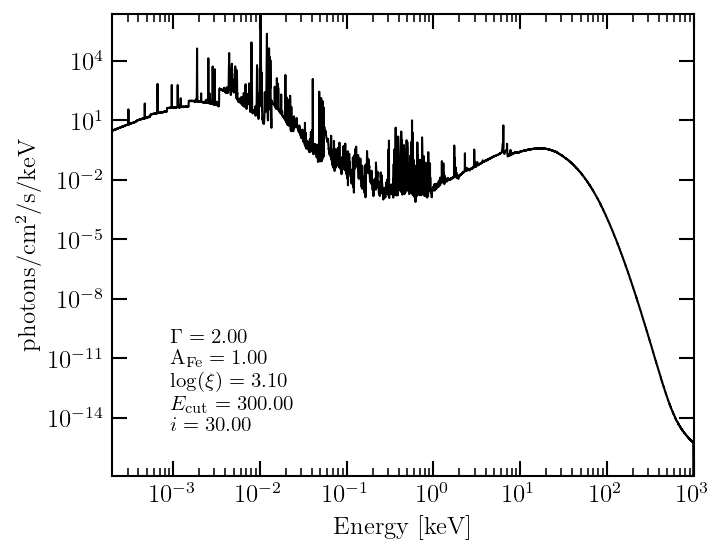

In [37]:
# Asia's figure configuration of choice


plotting.configure_plots()

fig, ax = plt.subplots()
ax.loglog(egrid, spec, c="k")

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$\rm photons / cm^2 / s / keV$")
ax.set_xlim(2e-4, 1e3)
ax.set_ylim(0.98 * spec.min(), 1.1 * spec.max())

gamma, Afe, logxi, Ecut, Incl = 2.0, 1.0, 3.1, 300, 30
pars = (
    r"$\Gamma=%.2f$" % gamma
    + "\n"
    + r"$\rm A_{Fe}=%.2f$" % Afe
    + "\n"
    + r"$\log(\xi)=%.2f$" % logxi
    + "\n"
    + r"$E_{\rm cut}=%.2f$" % Ecut
    + "\n"
    + r"$i=%.2f$" % Incl
)
ax.text(0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)

### Make a prediction for an arbitrary set of input parameters 

In [5]:
gamma = 2.5
Afe = 5.0
logxi = 3.0
Ecut = 200.0
Incl = 60.0

egrid, spec2 = emullver.emulated_spectrum(
    gamma=gamma, Afe=Afe, logxi=logxi, Ecut=Ecut, Incl=Incl, emulator=emulator
)

1/1 [==============================] - 0s 21ms/step


Text(0.1, 0.1, '$\\Gamma=2.50$\n$\\rm A_{Fe}=5.00$\n$\\log(\\xi)=3.00$\n$E_{\\rm cut}=200.00$\n$i=60.00$')

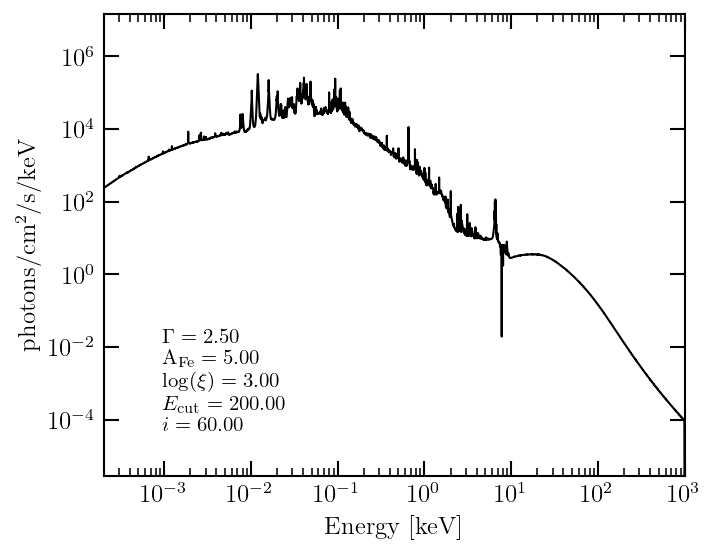

In [6]:
fig, ax = plt.subplots()
ax.loglog(egrid, spec2, c="k")

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$\rm photons / cm^2 / s / keV$")
ax.set_xlim(2e-4, 1e3)
ax.set_ylim(0.98 * spec2.min(), 1.1 * spec2.max())

pars = (
    r"$\Gamma=%.2f$" % gamma
    + "\n"
    + r"$\rm A_{Fe}=%.2f$" % Afe
    + "\n"
    + r"$\log(\xi)=%.2f$" % logxi
    + "\n"
    + r"$E_{\rm cut}=%.2f$" % Ecut
    + "\n"
    + r"$i=%.2f$" % Incl
)
ax.text(0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)

------
# Comparison with XSPEC 
### requires a choice of a xillver table and initialising HEASOFT


An example comparison with the parameter set defined above

In [12]:
gamma = 2 #1-3.4
Afe = 8 #0.5-10
logxi = 3 #0-4.69897
Ecut = 999.0 #20-1000
Incl = 50 #18.1949 - 87.134

from emullver import params_to_physical_units
from xspec_comparison import compare_spectra

In [11]:
with open("data.pickle", "rb") as handle:
    data = pickle.load(handle)

In [13]:
train_x = np.array(data['train_x']).reshape(62400, 5)
train_y = np.array(data['train_y']).reshape(62400, 4999)

In [14]:
from xspec import *

Xset.chatter = 0
Xset.logChatter = 0

In [45]:
stuff = []
visited = set()
from emullver import params_to_physical_units
from xspec_comparison import compare_spectra
    
for i in range(1):
    c_list = []
    d_list = []
    e_list = []
    error_list = []
    a = train_x[i][0]
    b = train_x[i][1]

    if (a, b) not in visited:

        visited.add((a, b))

        new = params_to_physical_units(train_x[i])
        for i in range(62400):
            x = train_x[i]
            new_x = params_to_physical_units(x)
            if x[0] == a and x[1] == b:
                c_list.append(new_x[2])
                d_list.append(new_x[3])
                e_list.append(new_x[4])

                new_x = params_to_physical_units(x)
                egrid_e, spec_e, egrid_x, spec_x = compare_spectra(
                        gamma=float(new_x[0]),
                        Afe=float(new_x[1]),
                        logxi=float(new_x[2]),
                        Ecut=float(new_x[3]),
                        Incl=float(new_x[4]),
                        emulator=emulator,
                        xillver_model=None,
                        table_path="./xillver-a-Ec4-full.fits",
                    )
                num = np.log10([x+1 for x in spec_e]) - np.log10([x+1 for x in spec_x])
                error = np.sqrt(np.mean(np.square(num / np.log10([x+1 for x in spec_x]))))
                error_list.append(error)

        stuff.append([a, b, c_list, d_list, e_list, error_list])



#         fig = plt.figure(figsize=(10, 8))
#         ax = fig.add_subplot(111, projection='3d')
#         surf = ax.scatter(c_list, d_list, e_list, c=error_list, cmap='viridis')  # You can choose any colormap you prefer
#         fig.colorbar(surf, ax=ax, label='Error')
#         ax.view_init(elev=30, azim=45)
#         ax.set_xlabel(r"$\log(\xi)$")
#         ax.set_ylabel(r"$E_{\rm cut}$")
#         ax.set_zlabel(r"$i$")
#         ax.zaxis.labelpad=-0.7
#         pars = (
#             r"$\Gamma=%.2f$" % new[0]
#             + "\n"
#             + r"$\rm A_{Fe}=%.2f$" % new[1]
#         )
#         ax.text(0.1, 0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)
#         plt.show()
            
            
print(len(stuff))

1/1 [==============================] - 0s 27ms/step


/tmp/ipykernel_1200177/1616821673.py:39: RuntimeWarning: divide by zero encountered in divide
  error = np.sqrt(np.mean(np.square(num / np.log10([x+1 for x in spec_x]))))
/tmp/ipykernel_1200177/1616821673.py:39: RuntimeWarning: invalid value encountered in divide
  error = np.sqrt(np.mean(np.square(num / np.log10([x+1 for x in spec_x]))))


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
1


In [46]:
data = sorted(stuff, key=lambda x: (x[0], x[1]))

In [51]:
%matplotlib notebook

<IPython.core.display.Javascript object>


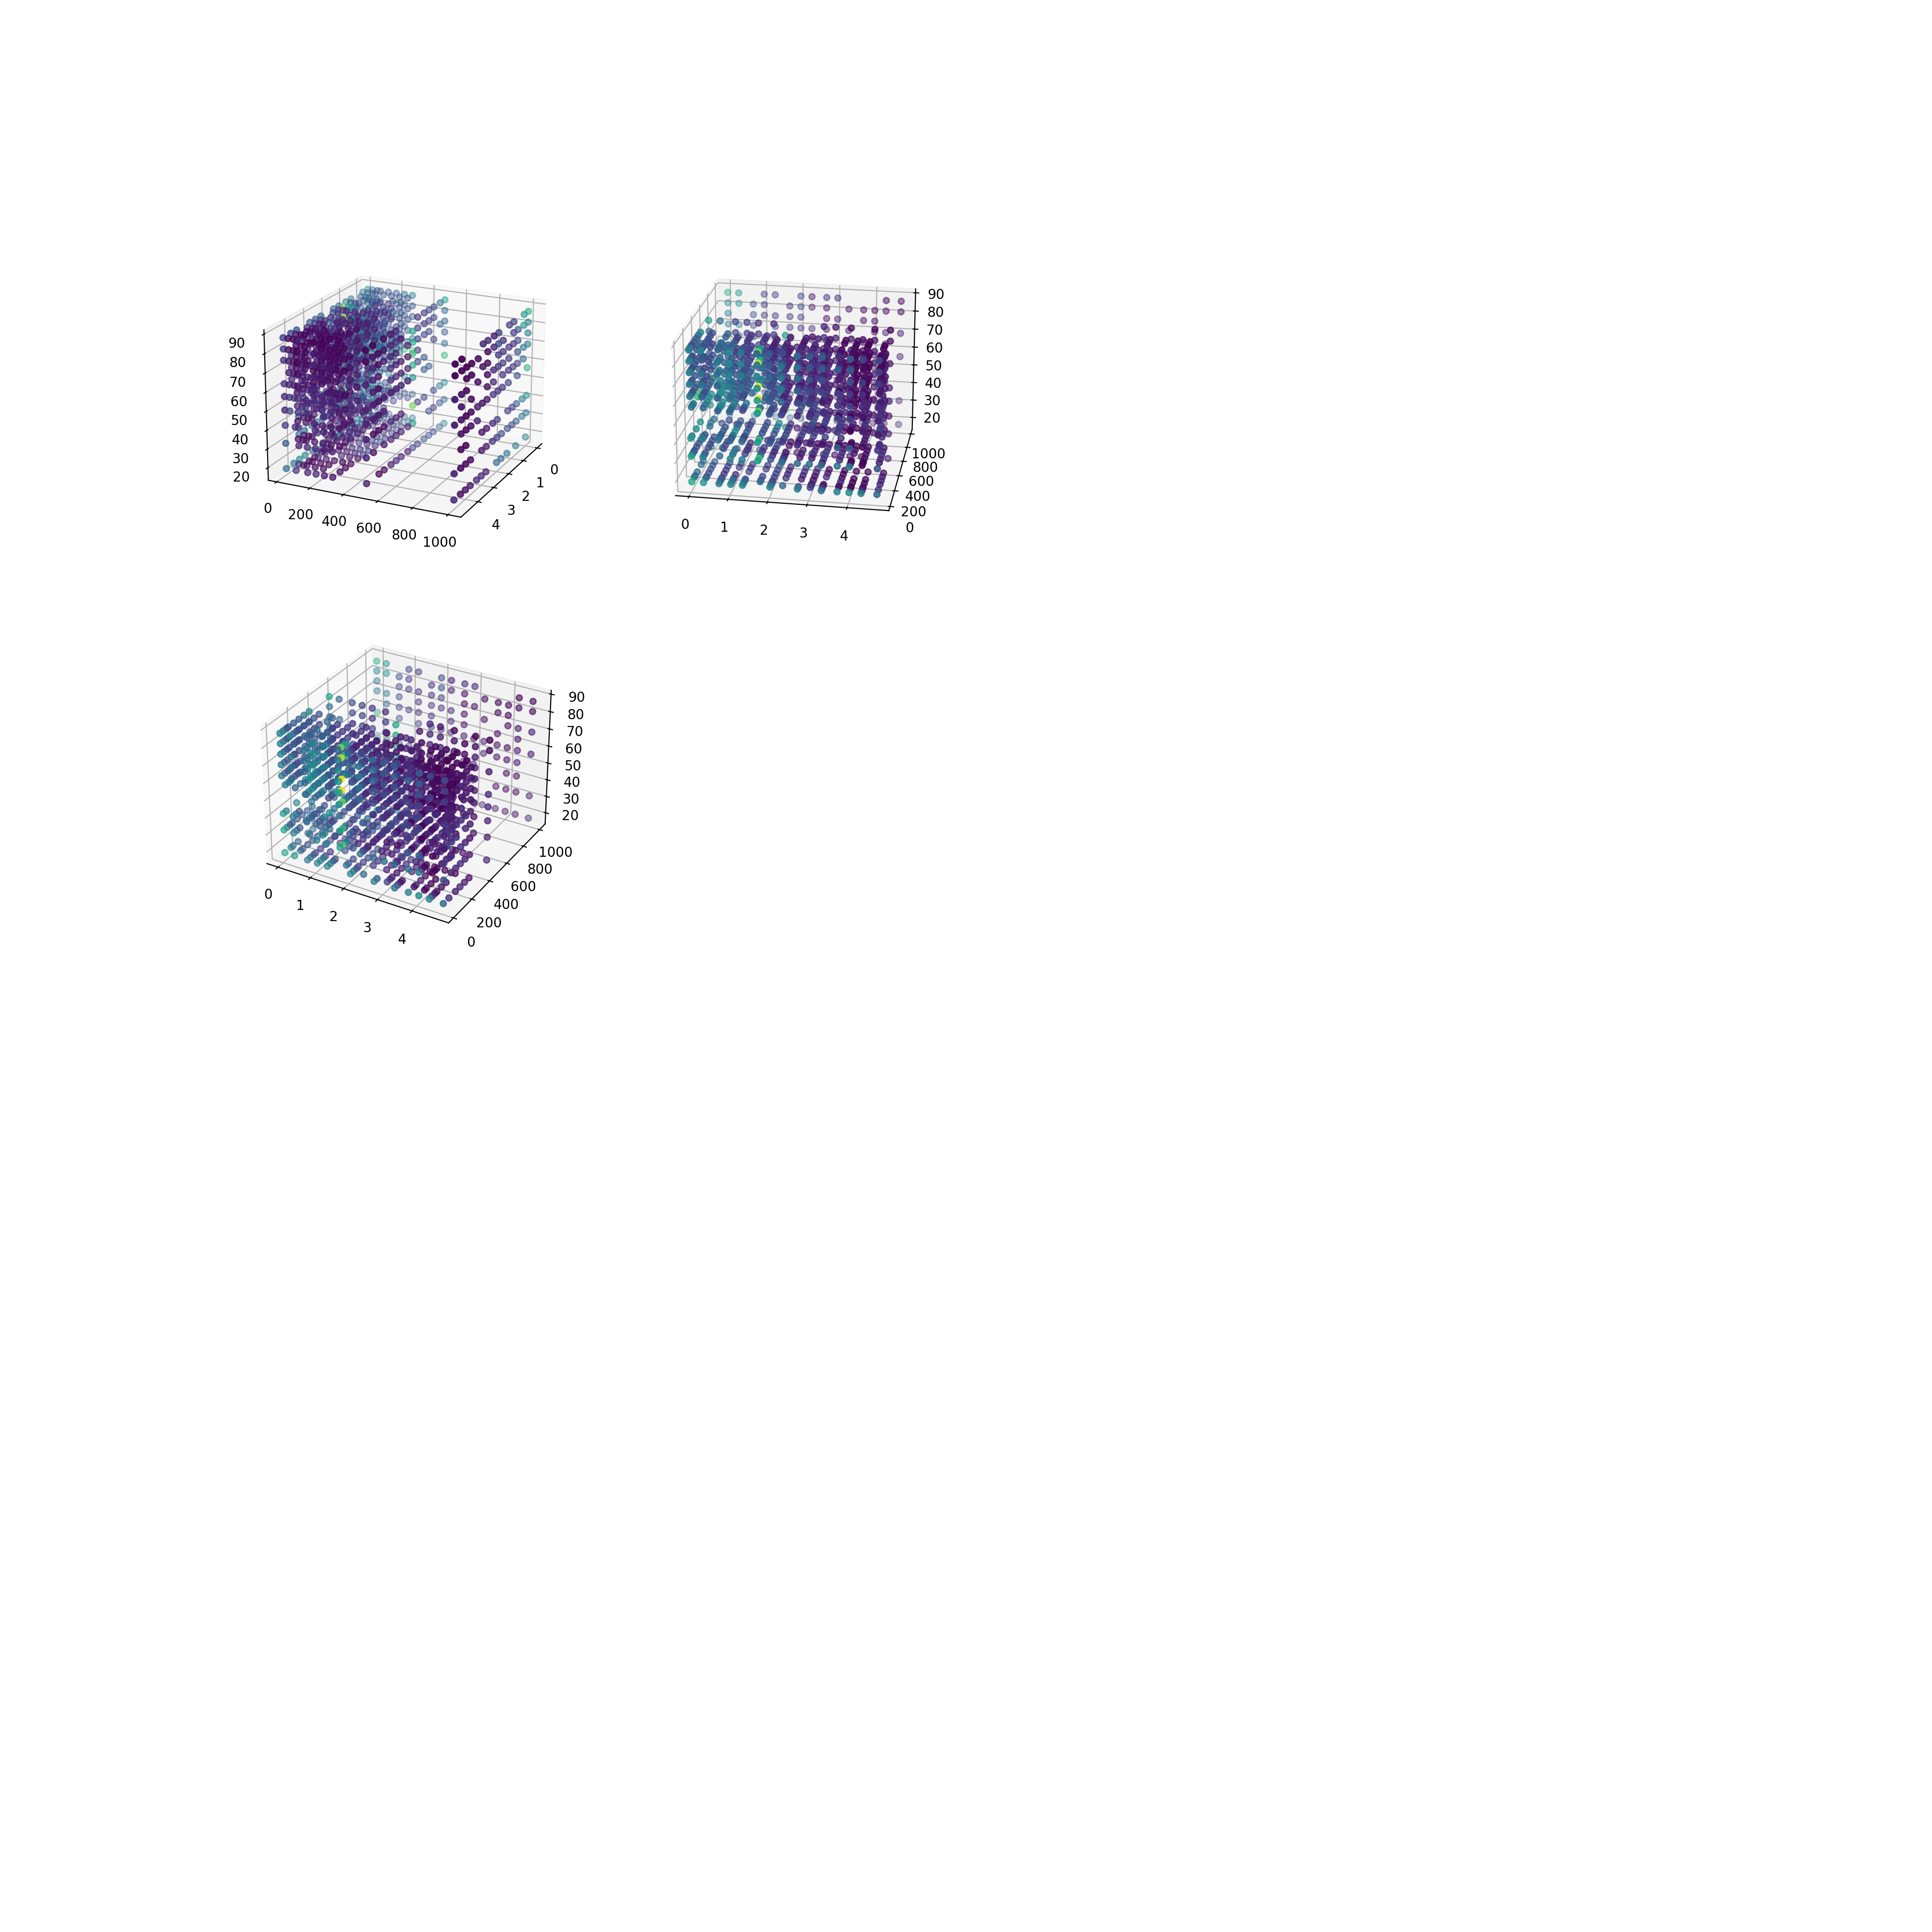

In [64]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(4, 4, 1, projection='3d')
ax.scatter3D(data[i][2], data[i][3], data[i][4], c=data[i][5], cmap='viridis')
# plt.show()
# fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(4, 4, 2, projection='3d')
ax.scatter3D(data[i][2], data[i][3], data[i][4], c=data[i][5], cmap='viridis')
ax = fig.add_subplot(4, 4, 5, projection='3d')
ax.scatter3D(data[i][2], data[i][3], data[i][4], c=data[i][5], cmap='viridis')
plt.show()
# for i in range(1):
#     ax = fig.add_subplot(4, 4, i+1, projection='3d')
#     surf = ax.scatter(data[i][2], data[i][3], data[i][4], c=data[i][5], cmap='viridis')  # You can choose any colormap you prefer
#     fig.colorbar(surf, ax=ax, label='Error')
#     ax.view_init(elev=30, azim=45)
#     ax.set_xlabel(r"$\log(\xi)$")
#     ax.set_ylabel(r"$E_{\rm cut}$")
#     ax.set_zlabel(r"$i$")
#     ax.zaxis.labelpad=-0.7
#     pars = (
#         r"$\Gamma=%.2f$" % data[i][0]
#         + "\n"
#         + r"$\rm A_{Fe}=%.2f$" % data[i][1]
#     )
#     ax.text(10, 0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)
        
# # from matplotlib.backends.backend_pdf import PdfPages
# # pp = PdfPages('foo.pdf')
# # pp.savefig(fig)
# # pp.close()

# plt.show()

In [ ]:
index = data[0][5]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim




In [35]:
model = nn.Sequential(
    nn.Linear(5, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 4999))


In [36]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
X = torch.tensor(train_x, dtype=torch.float32)
Y = torch.tensor(train_y, dtype=torch.float32)

In [37]:
n_epochs = 30
batch_size = 128
 
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 5.9843220710754395
Finished epoch 1, latest loss 3.3105766773223877
Finished epoch 2, latest loss 3.06581711769104
Finished epoch 3, latest loss 2.6016077995300293
Finished epoch 4, latest loss 2.234962224960327
Finished epoch 5, latest loss 1.803011417388916
Finished epoch 6, latest loss 1.7046409845352173
Finished epoch 7, latest loss 1.6365150213241577
Finished epoch 8, latest loss 1.406736135482788
Finished epoch 9, latest loss 1.2329503297805786
Finished epoch 10, latest loss 1.187697172164917
Finished epoch 11, latest loss 1.076707124710083
Finished epoch 12, latest loss 1.0244626998901367
Finished epoch 13, latest loss 0.9556114077568054
Finished epoch 14, latest loss 0.9304071068763733
Finished epoch 15, latest loss 0.8780025243759155
Finished epoch 16, latest loss 0.8445059061050415
Finished epoch 17, latest loss 0.807494580745697
Finished epoch 18, latest loss 0.7852288484573364
Finished epoch 19, latest loss 0.7939319014549255
Finished epoch 20,

In [38]:
with torch.no_grad():
    y_pred = model(X[1279])

/tmp/ipykernel_1200177/3393077587.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0.98 * y_pred.min(), 1.1 * y_pred.max())


Text(0.1, 0.1, '$\\Gamma=2.00$\n$\\rm A_{Fe}=8.00$\n$\\log(\\xi)=3.00$\n$E_{\\rm cut}=999.00$\n$i=50.00$')

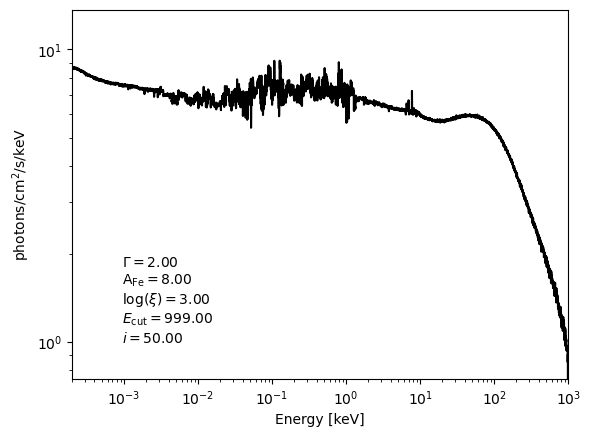

In [43]:
fig, ax = plt.subplots()
ax.loglog(egrid, y_pred, c="k")

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$\rm photons / cm^2 / s / keV$")
ax.set_xlim(2e-4, 1e3)
ax.set_ylim(0.98 * y_pred.min(), 1.1 * y_pred.max())

pars = (
    r"$\Gamma=%.2f$" % gamma
    + "\n"
    + r"$\rm A_{Fe}=%.2f$" % Afe
    + "\n"
    + r"$\log(\xi)=%.2f$" % logxi
    + "\n"
    + r"$E_{\rm cut}=%.2f$" % Ecut
    + "\n"
    + r"$i=%.2f$" % Incl
)
ax.text(0.1, 0.1, pars, transform=ax.transAxes, fontsize=10)

In [ ]:
#normalized loss
#more epochs
#see spectra for highest error
#spectra for best/worst emulated/medium
#add matzeu et al and the input (table) plus own emulator and which physical parameters
#from .fits to .hdf5
#use spectra from table and interpolate 0's
#plot residuals
#image this nn, the residuals, the spectra, 


#explore matzeu error
#comparison btw spectra with residuals for bad cases
#also include our own emulator too, with bad/good/mid cases, with table and matzeu
#interpolate zero's
#use astropy fits 85% training 10% test 5% valid

#1. loss as function of epochs
#2. scatterplots see spectra that are worst/best, with residuals
#3. fix the error
#4. interpolate the table
#5. compare our own emulator
#also keep the individual points/bins in addition to the overall error to see which pts most important .fits .hdf5 file

#then arch then data rep
#gpu acceleration

In [13]:
print(visited)

{(0.0, 1.0), (0.0, 0.0), (0.8333333, 1.0), (0.3333333, 1.0), (0.25, 0.05263158)}


In [32]:

# xillver_model = None
# table_path="./xillver-a-Ec4-full.fits",
# if xillver_model is None:
#     xspec.AllModels.setEnergies(_globals.ENERGY_BIN_FILE)

#     if table_path is None:
#         print("XILLVER model table path missing. Please fix!")
#     else:
#         xillver_model = xspec.Model("atable{%s}" % table_path)

#     xillver_model.setPars({1: gamma, 2: Afe, 3: logxi, 4: Ecut, 5: Incl})
#     energy_grid = (
#         xillver_model.energies(0)[:-1]
#         + np.diff(xillver_model.energies(0)) / 2.0
#     )

#     print(energy_grid, xillver_model.values(0))

[1.00164500e-04 1.00494501e-04 1.00825499e-04 ... 9.99847504e+02
 9.99949005e+02 1.00004999e+03] [27412.114828149934, 43527.645169240415, 16423272.823977083, 45729.61358737871, 44616.842105067044, 42112.268913076514, 38451.88152620428, 33967.714336327525, 29036.14243503724, 24030.04459209166, 19266.788363589898, 14979.403737558237, 11308.931212084546, 8304.607292129593, 5945.685951135265, 4163.02278369932, 2861.592552015666, 1941.103523024593, 1307.8258065269197, 882.5953457621024, 602.8349422936428, 421.72861644513955, 305.9631483375169, 232.45970224060073, 184.11563711838625, 156.00508648051868, 138.90001846171123, 127.95242021329885, 120.76987495170752, 117.025473213217, 114.79583257860209, 113.55810218353017, 112.93859947017432, 112.7686123612774, 112.94148666789724, 113.27813267657302, 113.71467697792673, 114.22298212139836, 114.77918808193581, 115.36943562545603, 115.98921610406438, 116.6194375943146, 117.27054456034544, 117.92484254108825, 118.59178327187695, 119.26374541895665,

In [35]:
from xspec_comparison import xspec_spectrum



XILLVER model table path missing. Please fix!


AttributeError: 'NoneType' object has no attribute 'setPars'

In [ ]:
from xspec_comparison import compare_spectra
means = []
for x, y in list(zip(train_x, train_y))[:5]:
    x = params_to_physical_units(x)
    egrid_e, spec_e, egrid_x, spec_x = compare_spectra(
            gamma=float(x[0]),
            Afe=float(x[1]),
            logxi=float(x[2]),
            Ecut=float(x[3]),
            Incl=float(x[4]),
            emulator=emulator,
            xillver_model=None,
            table_path="./xillver-a-Ec4-full.fits",
        )

    error = np.sqrt(np.mean(np.square(np.log10([x+1 for x in spec_e]) - np.log10([x+1 for x in spec_x]))))
    means.append(error)


In [ ]:
print(means)

In [ ]:
from emullver import params_to_physical_units
for x, y in list(zip(train_x, train_y))[:5]:
    x = params_to_physical_units(x)
    comparison_figure(
        gamma=float(x[0]),
        Afe=float(x[1]),
        logxi=float(x[2]),
        Ecut=float(x[3]),
        Incl=float(x[4]),
        emulator=emulator,
        table_path="./xillver-a-Ec4-full.fits",
        gridpoint="NO",
    )
                    

In [1]:
gamma = 2.5
Afe = 5.0
logxi = 3.0
Ecut = 200.0
Incl = 60.0    

comparison_figure(
        gamma=gamma,
        Afe=Afe,
        logxi=logxi,
        Ecut=Ecut,
        Incl=Incl,
        emulator=emulator,
        table_path="./xillver-a-Ec4-full.fits",
        gridpoint="NO",
    )

NameError: name 'comparison_figure' is not defined